In [0]:
cd data-collection-from-transportation-platforms-morocco

/content/drive/My Drive/data-collection-from-transportation-platforms-morocco


In [0]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import pandas as pd
from keras import backend as K
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, SpatialDropout1D, Activation, concatenate
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers.advanced_activations import ReLU, PReLU, LeakyReLU, ELU
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model,Sequential
from keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

In [0]:
pd.DataFrame(hist).to_csv('datasources/history.csv',sep=';',header=["user_id","trip_id","trafic","security","retard","accident"],index= False)

In [0]:
def f(x):
    x = int(x.split(":")[0])
    if (x > 4) and (x <= 8):
        return 1
    elif (x > 8) and (x <= 12 ):
        return 2
    elif (x > 12) and (x <= 16):
        return 3
    elif (x > 16) and (x <= 20) :
        return 4
    elif (x > 20) and (x <= 24):
        return 5
    elif (x <= 4):
        return 0
def g(x):
    if x == 'M':
        return 1
    return 2

def h(x):
    p = ['technician', 'other', 'writer', 'executive', 'administrator',
       'student', 'lawyer', 'educator', 'scientist', 'entertainment',
       'programmer', 'librarian', 'homemaker', 'artist', 'engineer',
       'marketing', 'none', 'healthcare', 'retired', 'salesman', 'doctor']
    for a,b in enumerate(p):
        if x  == b:
            return a

def ff(x):
    if x<30 :
        return 0
    elif x<60:
        return 1
    elif x<90:
        return 2
    else:
        return 3

In [0]:
def creatingDataset():
	trips = pd.read_csv('datasources/trips.csv',delimiter=';')
	users = pd.read_csv('datasources/users.csv',delimiter=';')
	history = pd.read_csv('datasources/history.csv',delimiter=';')
	trips["session"] = trips['depart'].apply(f)
	trips = trips.drop(axis=1,columns=['depart','Unnamed: 0'])
	users['profition'] = users['profition'].apply(h)
	users['sex'] = users['sex'].apply(g)
	users = users.drop(axis=1,columns=['id'])
	history['retard'] = history['retard'].apply(ff)
	rating = {}
	rating["0000"] =  5
	rating["0001"] =  4
	rating["0010"] =  5
	rating["0011"] =  5
	rating["0100"] =  4
	rating["0101"] =  3
	rating["0110"] =  4
	rating["0111"] =  3
	rating["0200"] =  3
	rating["0201"] =  2
	rating["0210"] =  3
	rating["0211"] =  2
	rating["0300"] =  2
	rating["0301"] =  1
	rating["0310"] =  2
	rating["0311"] =  1
	rating["1000"] =  3
	rating["1001"] =  2
	rating["1010"] =  3
	rating["1011"] =  2
	rating["1100"] =  2
	rating["1101"] =  1 
	rating["1110"] =  2
	rating["1111"] =  1
	rating["1200"] =  1
	rating["1201"] =  0
	rating["1210"] =  1
	rating["1211"] =  0
	rating["1300"] =  0
	rating["1301"] =  0
	rating["1310"] =  0
	rating["1311"] =  0
	rt = []
	for i in range(len(history)):
	    try :
	        rt.append([history['user_id'][i],history['trip_id'][i],history['accident'][i],history['retard'][i],history['security'][i],history['trafic'][i],rating[str(int(history['accident'][i]))+str(int(history['retard'][i]))+str(int(history['security'][i]))+str(int(history['trafic'][i]))]])
	    except :
	        pass
	X = []
	trips = trips.to_numpy()
	users = users.to_numpy()
	for r in rt:
	    X.append(np.concatenate([trips[r[1]],users[r[0]-1],r[2:-1]]))

	data = pd.DataFrame(X,columns=['company', 'from_lat', 'from_lan', 'to_lat', 'to_lan', 'distance','duration','dayofweek','price','session','age', 'gender', 'profission','accident','retard','security','trafic'])
	data['rating'] = np.array(rt)[:,-1]
	data.to_csv("dataset.csv",sep=';',index = False)

In [0]:
creatingDataset()

In [0]:
LABEL_COLUMN = "rating"

CATEGORICAL_COLUMNS = [
    'from', 'to' ,'session','gender', 'profission','dayofweek'
]

CONTINUOUS_COLUMNS = [
    'distance','duration', 'price','age'
]

In [0]:
def preprocessing():
    data = pd.read_csv('dataset.csv',delimiter =';')
    print(data.shape)
    # Convert the position of each starting city to a number 
    a = data.groupby(['from_lat','from_lan']).size()
    from_dict = {}
    for i,row in enumerate(a.iteritems()):
        from_dict[row[0]] = i
    f = data[['from_lat','from_lan']]
    from_col = []
    for a,b in f.iterrows():
        from_col.append(from_dict[(b['from_lat'],b['from_lan'])])
    data['from'] = from_col
    data = data.drop(['from_lat','from_lan'],axis = 1)
    # Convert the position of each arrival city to a number 
    a = data.groupby(['to_lat','to_lan']).size()
    from_dict = {}
    for i,row in enumerate(a.iteritems()):
        from_dict[row[0]] = i
    f = data[['to_lat','to_lan']]
    from_col = []
    for a,b in f.iterrows():
        from_col.append(from_dict[(b['to_lat'],b['to_lan'])])
    data['to'] = from_col
    data = data.drop(['to_lat','to_lan'],axis = 1)
    
    for c in CATEGORICAL_COLUMNS:
        le = LabelEncoder()
        data[c] = le.fit_transform(data[c])
    # train,validation,test split
    train=data.sample(frac=0.8,random_state=200)
    val = data.drop(train.index).sample(frac = 0.5,random_state=200)
    test=data.drop(train.index).drop(val.index)
    
    y_train = train['rating'].values
    y_val = val['rating'].values
    y_test = test['rating'].values
    x_train = train.drop(['rating'],axis=1)
    x_val = val.drop(['rating'],axis=1)
    x_test = test.drop(['rating'],axis=1)
    x_train_categ = np.array(x_train[CATEGORICAL_COLUMNS]) 
    x_val_categ = np.array(x_val[CATEGORICAL_COLUMNS])
    x_test_categ = np.array(x_test[CATEGORICAL_COLUMNS])
    x_train_conti = np.array(x_train[CONTINUOUS_COLUMNS], dtype='float64') 
    x_val_conti = np.array(x_val[CONTINUOUS_COLUMNS], dtype='float64')
    x_test_conti = np.array(x_test[CONTINUOUS_COLUMNS], dtype='float64')

    scaler = StandardScaler()
    x_train_conti = scaler.fit_transform(x_train_conti)
    x_val_conti = scaler.transform(x_val_conti)    
    x_test_conti = scaler.transform(x_test_conti)
    return [x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ, x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data]

In [0]:
ACCURACY_THRESHOLD = 0.99
class MyCustomCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    if(logs.get('acc') >= ACCURACY_THRESHOLD):   
        print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
        self.model.stop_training = True

callback = MyCustomCallback()

In [0]:
def swish(x):
    return (K.sigmoid(x) * x)

In [0]:
class Wide_and_Deep:
    def __init__(self,x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ,x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data):
        self.x_train = x_train
        self.y_train = to_categorical(y_train)
        self.x_val = x_val
        self.y_val = to_categorical(y_val)
        self.x_test = x_test
        self.y_test = to_categorical(y_test)
        self.x_train_categ = x_train_categ 
        self.x_val_categ = x_val_categ 
        self.x_test_categ = x_test_categ 
        self.x_train_conti = x_train_conti 
        self.x_test_conti = x_test_conti 
        self.x_val_conti = x_val_conti 
        self.all_data = data
        self.poly = PolynomialFeatures(degree=2, interaction_only=True)
        self.x_train_categ_poly = self.poly.fit_transform(x_train_categ)
        self.x_test_categ_poly = self.poly.transform(x_test_categ)
        self.x_val_categ_poly = self.poly.transform(x_val_categ)
        self.categ_inputs = None
        self.conti_input = None
        self.deep_component_outlayer = None
        self.logistic_input = None
        self.model = None
    
    def deep_component(self,layers,embed_size,batch_norm):
        categ_inputs = []
        categ_embeds = []
        # Create Input layer and Embedding layer for each feature of category data
        for i in range(len(CATEGORICAL_COLUMNS)):
            input_i = Input(shape=(1,), dtype='int32')
            dim = len(np.unique(self.all_data[CATEGORICAL_COLUMNS[i]]))
            embed_dim = embed_size #int(np.ceil(dim ** 0.25)) # TO TUNE
            embed_i = Embedding(dim, embed_dim, input_length=1,trainable = True)(input_i)
            flatten_i = Flatten()(embed_i)
            categ_inputs.append(input_i)
            categ_embeds.append(flatten_i)
        # Continuous data is input collectively in all connected layers
        conti_input = Input(shape=(len(CONTINUOUS_COLUMNS),))
        conti_dense = Dense(embed_size)(conti_input)
        # Attach the output of all connected layers and each Embedding
        concat_embeds = concatenate([conti_dense]+categ_embeds)
        out = ReLU()(concat_embeds)
        if batch_norm :
          out = BatchNormalization()(out)
        # Furthermore, three layers of all bonding layers are stacked
        for layer in layers:
          out = Dense(layer)(out)
          out = ReLU()(out)
          if batch_norm:
            out = BatchNormalization()(out)
        # Convert input and last layers into member variables (for model creation)
        self.categ_inputs = categ_inputs
        self.conti_input = conti_input
        self.deep_component_outlayer = out
    
    def wide_component(self):
        # Include only category data in linear model
        dim = self.x_train_categ_poly.shape[1]
        self.logistic_input = Input(shape=(dim,))

    def create_model(self,layers,embedding_size=16,batch_norm=True):
        # create the separate components 
        self.deep_component(layers[0],embedding_size,batch_norm)
        self.wide_component()
        out_layer = concatenate([self.deep_component_outlayer, self.logistic_input])
        out_layer = ReLU()(out_layer)
        for layer in layers[1]:
          if batch_norm:
            out_layer = BatchNormalization()(out_layer)
            out_layer = Dense(layer)(out_layer)
            out_layer = ReLU()(out_layer)

        inputs = [self.conti_input] + self.categ_inputs + [self.logistic_input]
        output = Dense(self.y_train.shape[1], activation='softmax')(out_layer)
        self.model = Model(inputs=inputs, outputs=output)
        
    def train_model(self, epochs=15, optimizer='adam', batch_size=64):
        train_data = [self.x_train_conti] +\
                      [self.x_train_categ[:, i] for i in range(self.x_train_categ.shape[1])] +\
                      [self.x_train_categ_poly]
        val_data =   [self.x_val_conti] +\
                      [self.x_val_categ[:, i] for i in range(self.x_train_categ.shape[1])] +\
                      [self.x_val_categ_poly]

        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        self.model.fit(train_data, self.y_train,validation_data=(val_data,self.y_val) ,epochs=epochs, batch_size=batch_size)

    def evaluate_model(self):
      input_data = [self.x_test_conti] +\
                    [self.x_test_categ[:, i] for i in range(self.x_test_categ.shape[1])] +\
                    [self.x_test_categ_poly]
      loss, acc = self.model.evaluate(input_data, self.y_test)
      print(f'test_loss: {loss} - test_acc: {acc}')

    def save_model(self, filename='wide_and_deep.h5'):
      self.model.save(filename)

In [0]:
x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ,x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data = preprocessing()

(943000, 18)


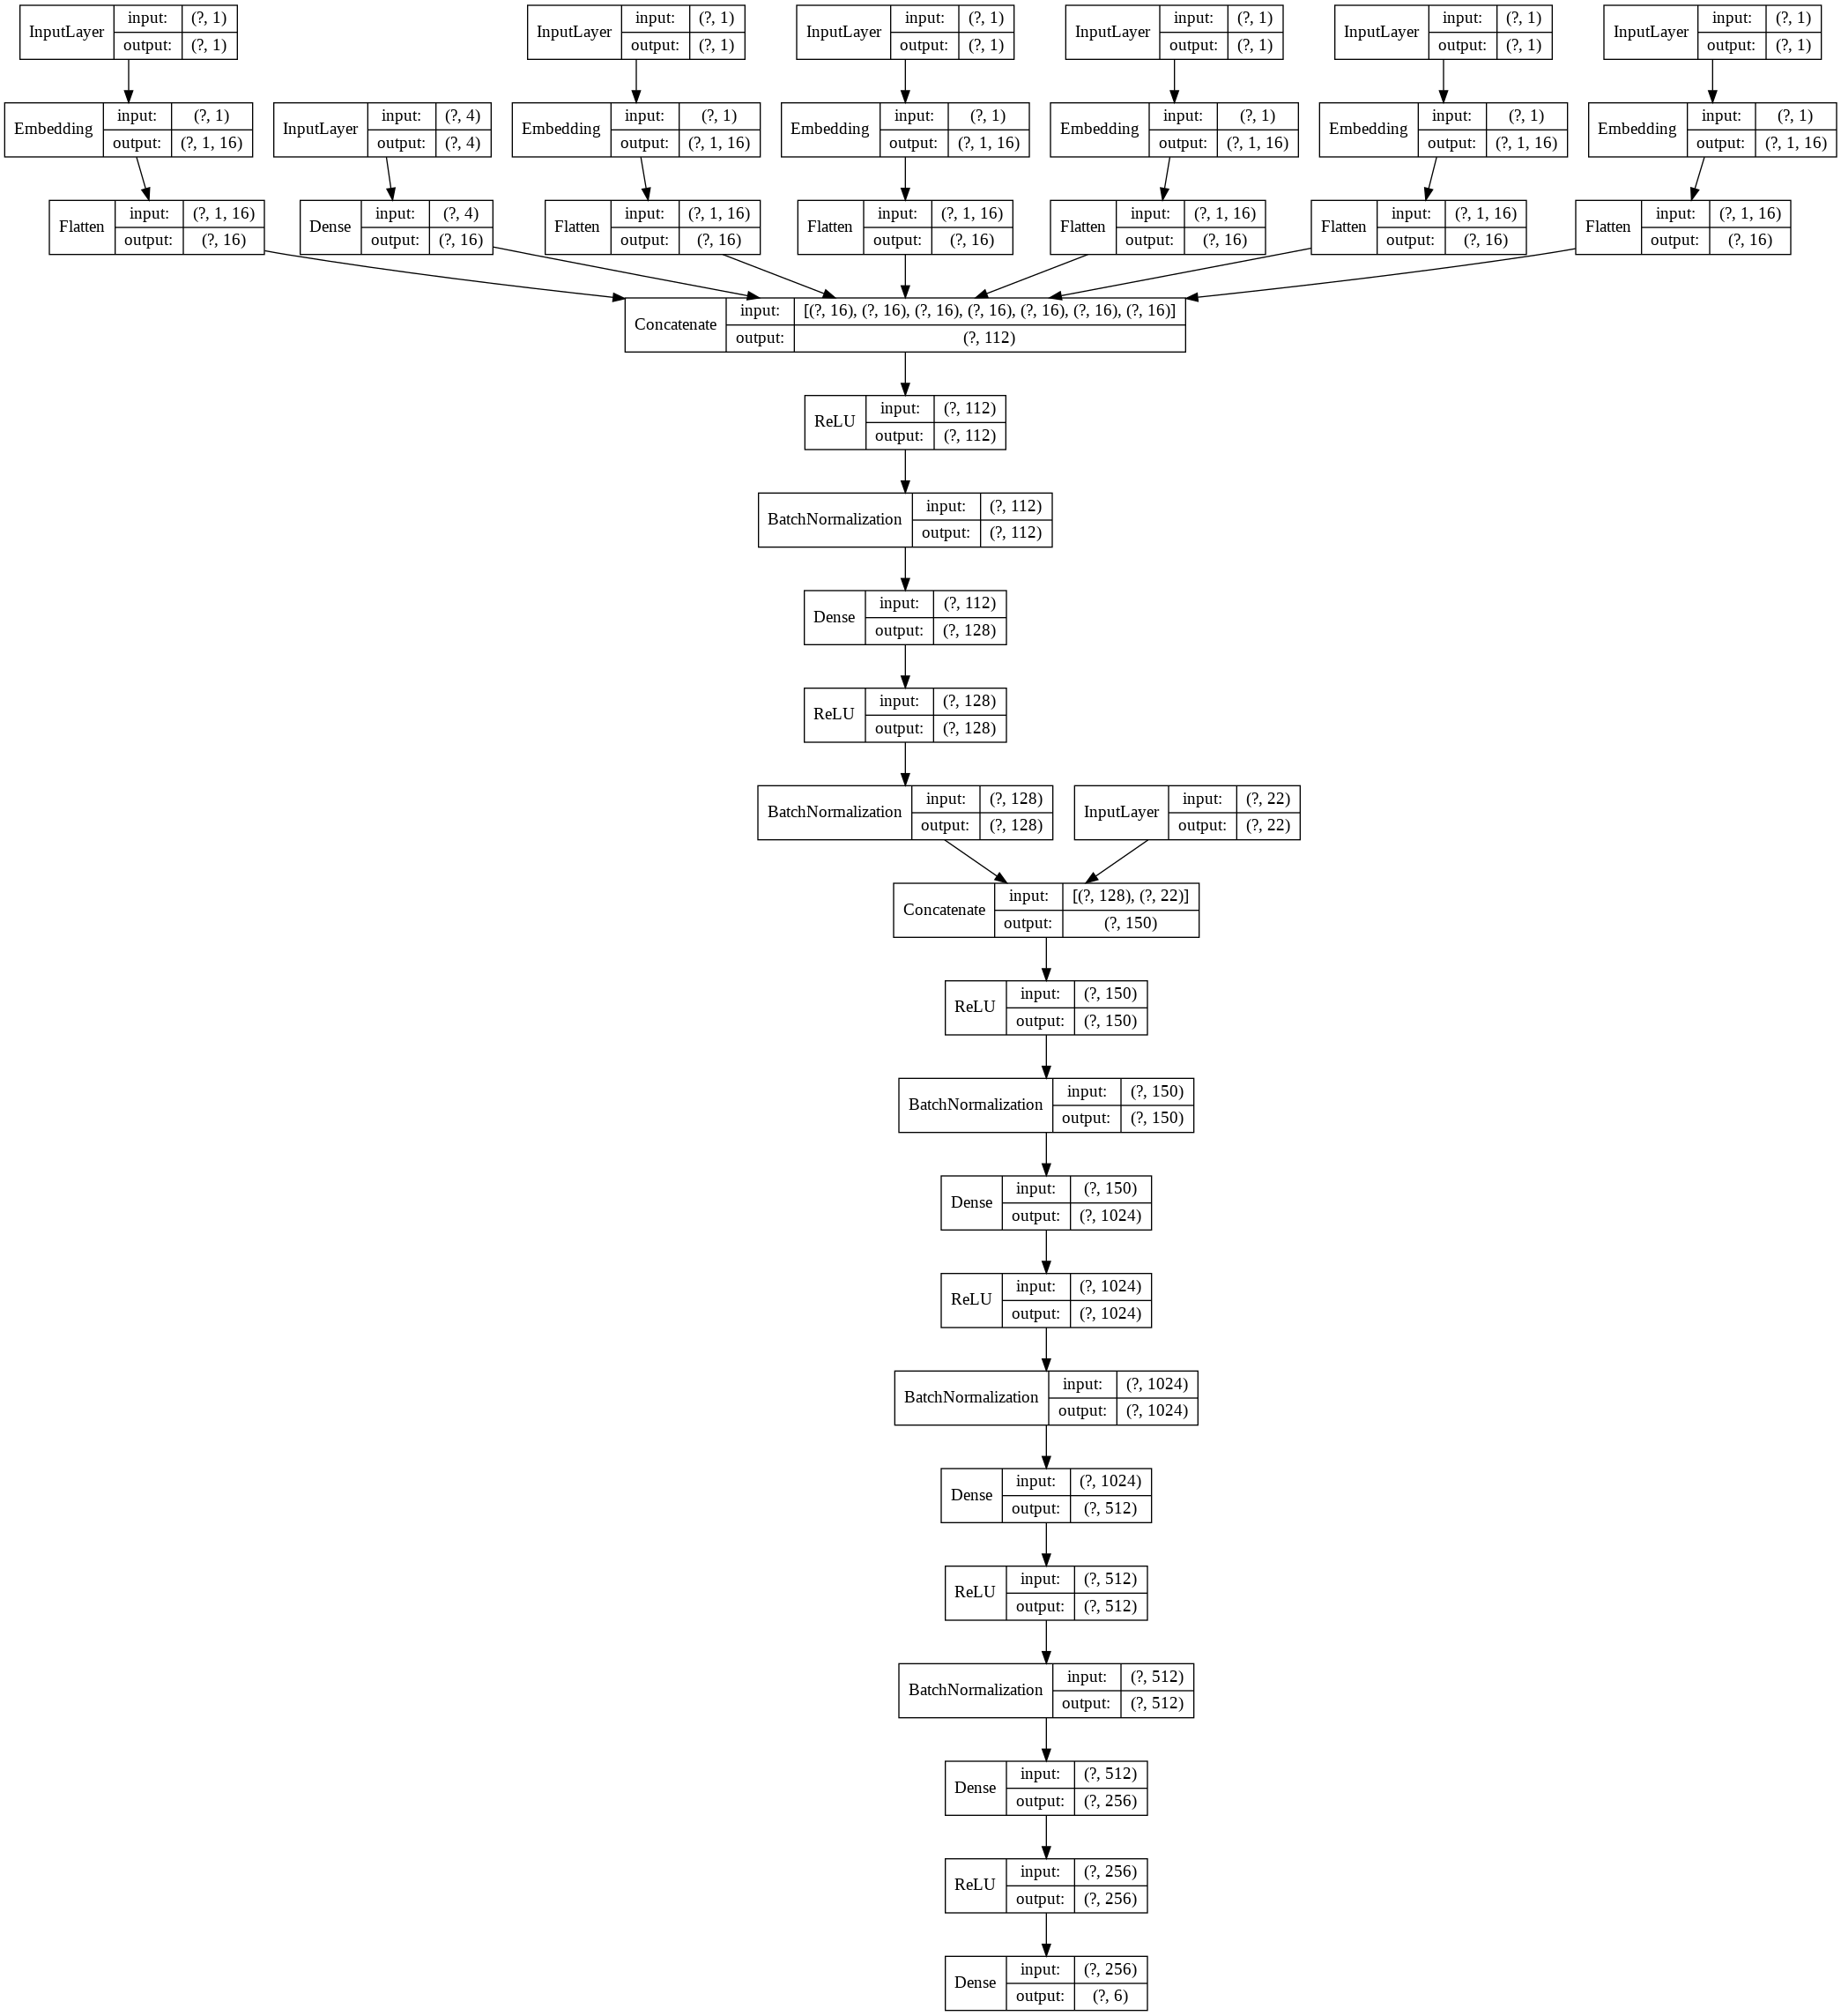

In [53]:
wide_deep_net = Wide_and_Deep(x_train, y_train, x_val, y_val, x_test, y_test, x_train_categ,x_val_categ, x_test_categ, x_train_conti,x_val_conti, x_test_conti, data)
wide_deep_net.create_model(layers=[[128],[1024,512,256]])
plot_model(wide_deep_net.model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [55]:
wide_deep_net.train_model()

KeyboardInterrupt: ignored

In [52]:
wide_deep_net.evaluate_model()

94300/94300 [==============================] - 5s 50us/step
test_loss: 0.6425868949606968 - test_acc: 0.7175609469413757


In [0]:
def CreateModel(input_size,out_size):
  model = Sequential()
  model.add(Dense(units=128,activation='relu',input_dim=input_size))
  model.add(Dense(units=64,activation='relu'))
  model.add(Dense(units=32,activation='relu'))
  model.add(Dense(units=out_size,activation='softmax'))

  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
  return model

In [0]:
data = pd.read_csv('dataset.csv',delimiter =';')
y = data['rating'].values
data = data.drop(axis=1,columns=['accident','retard','security','trafic','rating'])
X = data.to_numpy()
y = to_categorical(y)
model = CreateModel(X.shape[1],y.shape[1])
model.fit(X,y,epochs=10,batch_size=64)